# Spark Project 

We need to create the spark context

In [1]:
import pandas as pd
from pyspark import SparkContext
from pyspark.sql import SQLContext          

In [2]:
sc = SparkContext()
sql_sc = SQLContext(sc)

## Data preparation : 

#### Merge all the files

In [3]:
from shutil import copyfileobj
with open('Price.csv','wb') as wfd:
    for f in ["Prix2014.csv",'Prix2015.csv','Prix2016.csv']:
        with open(f,'rb') as fd:
            copyfileobj(fd, wfd, 1024*1024*10)

In [4]:
ddf = sql_sc.read.option('header', 'false').option('inferSchema', 'true').option('delimiter', ';').csv('Price.csv')

In [5]:
ddf.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- _c1: integer (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: double (nullable = true)
 |-- _c4: double (nullable = true)
 |-- _c5: timestamp (nullable = true)
 |-- _c6: integer (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: integer (nullable = true)



The first thing to do is to change the columns names.

In [6]:
from functools import reduce

oldColumns = ddf.schema.names
newColumns = ["id", "cp","pop","latitude","longitude","date","gas_id","gas_label","price"]

ddf = reduce(lambda ddf, idx: ddf.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), ddf)

In [7]:
ddf.printSchema()

root
 |-- id: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- pop: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- gas_id: integer (nullable = true)
 |-- gas_label: string (nullable = true)
 |-- price: integer (nullable = true)



#### Check if the database has some issues

In [8]:
ddf.count()

9401381

There are 9 401 381 rows in this dataset. We will check if the data base contains the value null and remove them if it is the case.

In [7]:
from pyspark.sql.functions import isnull, when, count, col
ddf.select([count(when(isnull(c), c)).alias(c) for c in ddf.columns]).show()

+---+---+---+--------+---------+----+------+---------+-----+
| id| cp|pop|latitude|longitude|date|gas_id|gas_label|price|
+---+---+---+--------+---------+----+------+---------+-----+
|  0|  0|  0|    9686|     9386|6586|  6586|     6586| 6586|
+---+---+---+--------+---------+----+------+---------+-----+



The value null is associated to some variables as latitude longitude, date, gas_id,gas_label and price. We need to remove them.

In [10]:
ddf.filter(ddf.gas_id.isNull() & ddf.gas_label.isNull() & ddf.price.isNull()).count()

6586

We have checked that when there is the value null in gas_id, the value is also null in  gas_label and price. So if we remove in one of these columns then it will be remove in the other columns too.

In [8]:
ddf.filter(ddf.gas_id.isNull() & ddf.date.isNull()).count()

6586

We see that the value is null in gas_id, the value in date is also null. <br>
<br>
So to remove the null value in the columns date,gas_id,gas_label,price we need to remove just in one of these columns.

In [12]:
ddf.filter(ddf.longitude.isNull() & ddf.latitude.isNull()).count()

9386

We see if there is a missing value in longitude, there will be a missing value in latitude too but the inverse is not necessarly true. So we need to remove the missing values in latitude and then it will be remove in the longitude.  

In [13]:
ddf.filter(ddf.gas_id.isNull() & ddf.latitude.isNull()).count()

228

We see that only 228 rows have an issue with the gas_id and the latitude and longitude so if we remove all the null we will remove 16044 (=9686+6586-228) rows. This number is not a lot compare to 9 millions rows. So we will do that.

In [14]:
assert ddf.count()== ddf.filter(ddf.latitude.isNotNull()& ddf.date.isNotNull()).count()+ddf.filter(ddf.gas_id.isNull()).count()+ ddf.filter(ddf.latitude.isNull()).count()-ddf.filter(ddf.gas_id.isNull() & ddf.latitude.isNull()).count(),"Problem"

There is no "Problem".  So we will remove these 160444 rows .

In [8]:
ddf=ddf.filter(ddf.latitude.isNotNull()& ddf.date.isNotNull())

#### Split data in year, month, weak of the year.

As sql queries will be use, the table needs to be register.

In [9]:
ddf.registerTempTable("PRICES")

We can see how the date is written in the table : 

In [27]:
sql_sc.sql("select date from PRICES ").show(5)

+-------------------+
|               date|
+-------------------+
|2014-01-02 11:08:03|
|2014-01-04 09:54:03|
|2014-01-05 10:27:09|
|2014-01-06 09:07:51|
|2014-01-07 09:23:56|
+-------------------+
only showing top 5 rows



We will use SQL functions to get the month, the year and the week of the year.

In [10]:
ddf=sql_sc.sql("select PRICES.*,Year(date) AS Year,Month(date) AS Month,weekofyear(date) AS Week from PRICES")

In [13]:
ddf.printSchema()

root
 |-- id: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- pop: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- gas_id: integer (nullable = true)
 |-- gas_label: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Week: integer (nullable = true)



We see that the variables Year,Month and Week have been added.

In [11]:
ddf.registerTempTable("PRICES")

#### Prepare latitude and longitude for mapping

In [20]:
sql_sc.sql("select max(latitude),min(latitude), max(longitude),min(longitude) from PRICES").show()

+---------------+--------------+--------------+--------------+
|  max(latitude)| min(latitude)|max(longitude)|min(longitude)|
+---------------+--------------+--------------+--------------+
|5546412.8983185|-2433288.11503| 6178073.52057|-6841787.14211|
+---------------+--------------+--------------+--------------+



The latitude must be a number between -90 and 90. <br>
The longitude must be a number between -180 and 180.<br>

So with the table we get previously, we deduce that we must multiply by 10E-5 for both of these quantities.

In [22]:
sql_sc.sql("select max(latitude*POWER(10,-5)) AS max_lat,max(longitude*POWER(10,-5)) AS max_long from PRICES ").show(5)


+------------------+------------------+
|           max_lat|          max_long|
+------------------+------------------+
|55.464128983185006|61.780735205700005|
+------------------+------------------+



In [12]:
ddf=sql_sc.sql("select PRICES.*,latitude*POWER(10,-5) AS Latitude, longitude*POWER(10,-5) AS Longitude from PRICES")
ddf.printSchema()

root
 |-- id: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- pop: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- gas_id: integer (nullable = true)
 |-- gas_label: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Week: integer (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)



We see that new columns have been added : Latitude and Longitude.

In [13]:
ddf.registerTempTable("PRICES")

The data is available as a table under the name PRICES.

#### Price index for each station per week

In [25]:
ddf.select("gas_label").distinct().count()

6

We see that there are 6 different types of gaz sold.

In [26]:
ddf.select("gas_label","gas_id").distinct().show()

+---------+------+
|gas_label|gas_id|
+---------+------+
|     SP98|     6|
|     SP95|     2|
|      E10|     5|
|      E85|     3|
|     GPLc|     4|
|   Gazole|     1|
+---------+------+



I will compute the mean of the price per week for each gas and associate it to a table "MEAN_GAS_PRICES" to be able to do queries on it.

In [14]:
gas_avg=sql_sc.sql("select AVG(price) AS avg_price,Week,Year,gas_id from PRICES group by gas_id,Week,Year") 
gas_avg.registerTempTable("MEAN_GAS_PRICES")

We can check if the result get by this function is coherent by checking if the number of results get by this function is equal to the sum of the number of weeks from the year 2014 to 2016.

In [17]:
gas_avg.count()

948

In [11]:
ddf[ddf["Year"]==2014].agg({"Week":"max"}).show()
ddf[ddf["Year"]==2015].agg({"Week":"max"}).show()
ddf[ddf["Year"]==2016].agg({"Week":"max"}).show()

+---------+
|max(Week)|
+---------+
|       52|
+---------+

+---------+
|max(Week)|
+---------+
|       53|
+---------+

+---------+
|max(Week)|
+---------+
|       53|
+---------+



The year 2014 had 52 weeks, the year 2015 had 53 weeks and the year 2016 had 53 weeks. As there are 6 types of gas, the number of rows in gas_avg must be 6*(numbers of weeks in 2014,2015 and 2016). 

In [291]:
assert gas_avg.count()==(52+53+53)*6,"Problem"

There is no "Problem" so the result seems good. <br>

We can also check that the mean computing by the function correspond to the mean per gas type per week per year.

In [28]:
gas_avg[(gas_avg["Week"]==1) & (gas_avg["Year"]==2014)].show()
gas_avg[(gas_avg["Week"]==2) & (gas_avg["Year"]==2014)].show()
gas_avg[(gas_avg["Week"]==2) & (gas_avg["Year"]==2015)].show()

+------------------+----+----+------+
|         avg_price|Week|Year|gas_id|
+------------------+----+----+------+
|1404.0323498964804|   1|2014|     2|
|  845.184855233853|   1|2014|     4|
|1444.3778141235327|   1|2014|     6|
| 889.9154929577464|   1|2014|     3|
|1380.6963530655391|   1|2014|     5|
|1222.1208775654636|   1|2014|     1|
+------------------+----+----+------+

+------------------+----+----+------+
|         avg_price|Week|Year|gas_id|
+------------------+----+----+------+
| 1551.755705832629|   2|2014|     6|
| 1333.624184460261|   2|2014|     1|
| 913.2693032015065|   2|2014|     3|
|  858.315913094539|   2|2014|     4|
|1487.0909613450208|   2|2014|     5|
|  1509.02585499316|   2|2014|     2|
+------------------+----+----+------+

+------------------+----+----+------+
|         avg_price|Week|Year|gas_id|
+------------------+----+----+------+
|1339.5928267855293|   2|2015|     6|
| 870.5302491103203|   2|2015|     3|
| 1131.053119567317|   2|2015|     1|
| 1289.806

For each query, we have 6 results wich correspond to the 6 types of gas. The result is different according the week and the year so the result seems good. <br>

Now, we add to the original table, the column avg_price. To do that we make an inner join on the variable week and year. 

In [15]:
ddf=sql_sc.sql("select PRICES.*,MEAN_GAS_PRICES.avg_price from PRICES inner join  MEAN_GAS_PRICES on PRICES.Year=MEAN_GAS_PRICES.Year and MEAN_GAS_PRICES.Week=PRICES.Week and MEAN_GAS_PRICES.gas_id=PRICES.gas_id")

In [16]:
ddf.registerTempTable("PRICES")

In [15]:
sql_sc.sql("select price,avg_price,gas_id from PRICES where Week=1  and Year=2014 and gas_id=1").distinct().show(5)

+-----+------------------+------+
|price|         avg_price|gas_id|
+-----+------------------+------+
| 1179|1222.1208775654636|     1|
| 1124|1222.1208775654636|     1|
| 1083|1222.1208775654636|     1|
| 1232|1222.1208775654636|     1|
| 1029|1222.1208775654636|     1|
+-----+------------------+------+
only showing top 5 rows



We see that for the same week and same year, there are different prices but the same mean so it is working.<br>

So now we can compute the price index thanks to the formula given in the pdf and add the result in a column called Price_index.

In [17]:
ddf=sql_sc.sql("select PRICES.*,100*(((price -avg_price)/avg_price)+1) AS Price_index,price,Week from PRICES" )

In [18]:
ddf.registerTempTable("PRICES")

#### Week Index

First we create a table which contains only the index, the week and the year to see if the sql query is working.

In [18]:
ddf_essai=sql_sc.sql("select case when Year=2014 then Week when Year=2015 then Week+52 when Year=2016 then Week+52+53 END AS Index,Week,Year from PRICES")


In [31]:
ddf_essai[ddf_essai["Week"]==1].distinct().show(5)

+-----+----+----+
|Index|Week|Year|
+-----+----+----+
|   53|   1|2015|
|  106|   1|2016|
|    1|   1|2014|
+-----+----+----+



For the week 1 for each year, the index is different and correspond to what we want. So it is working. <br>
We add this column to our table.

In [19]:
ddf=sql_sc.sql("select case when Year=2014 then Week when Year=2015 then Week+52 when Year=2016 then Week+52+53 END AS Index,* from PRICES")
ddf.registerTempTable("PRICES")

## Data visualization : 

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

To do graph, we need to import the pyspark object in python thanks to panda. As we only need of the gas type,the average price and the index we will import only these variables.

In [21]:
df=ddf.select("Index","avg_price","gas_label").distinct().toPandas()

/home/solenn/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


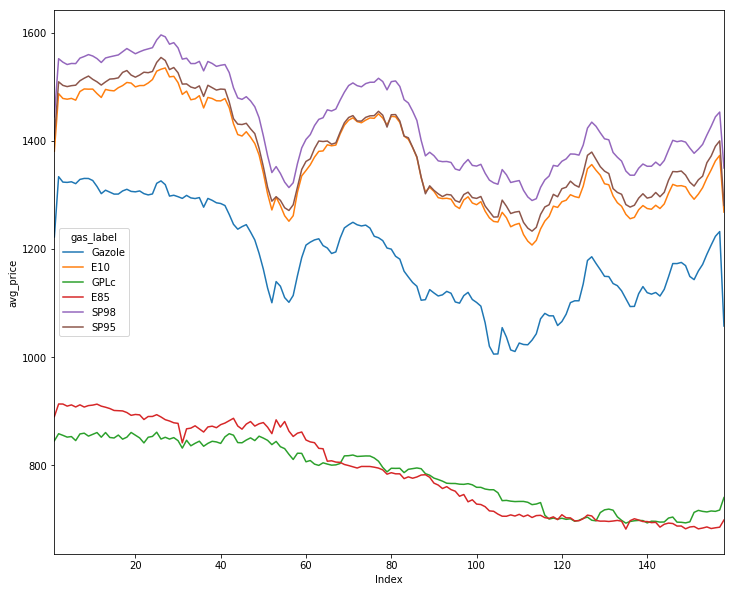

In [47]:
week_index, gas_label= np.meshgrid(np.arange(158), np.arange(1,6))
plt.figure(figsize=(12,10))
sns.tsplot(df, time='Index', unit = "gas_label", 
               condition='gas_label', value='avg_price')
plt.show()

Normally we should take in account the price index because it's the evolution during a period.

#### heatmaps of price indexes

As before, as we want to have a graph, we need to import our variables of interest into Pandas.

In [215]:
df1=ddf.select("Index","gas_label","Price_index").distinct().toPandas()

There is several values for each gas each week because there are several station services in the dataset. So to have only one value for each week, we compute the mean.

In [216]:
df1=df1.groupby(['gas_label', 'Index'], as_index=False).mean()

In [217]:
import numpy as np
from pandas import DataFrame
import seaborn as sns

Then we need to transform the data in the right format to plot the heatmap.

In [218]:
first_gas=df1[df1["gas_label"]=="E10"].sort_values(by=['gas_label',"Index"])
second_gas=df1[df1["gas_label"]=="Gazole"].sort_values(by=['gas_label',"Index"])
third_gas=df1[df1["gas_label"]=="GPLc"].sort_values(by=['gas_label',"Index"])
fourth_gas=df1[df1["gas_label"]=="E85"].sort_values(by=['gas_label',"Index"])
fifth_gas=df1[df1["gas_label"]=="SP95"].sort_values(by=['gas_label',"Index"])
sixth_gas=df1[df1["gas_label"]=="SP98"].sort_values(by=['gas_label',"Index"])


In [219]:
plot_1=np.array([first_gas["Price_index"].values,second_gas["Price_index"].values,third_gas["Price_index"].values,fourth_gas["Price_index"].values,fifth_gas["Price_index"].values,sixth_gas["Price_index"].values])
x=[plot_1[0].tolist(),plot_1[1].tolist(),plot_1[2].tolist(),plot_1[3].tolist(),plot_1[4].tolist(),plot_1[5].tolist()]
df_plot=DataFrame(x,index=["E10","Gazole","GPLc","E85","SP95","SP98"],columns=df1["Index"].sort_values().unique()) 

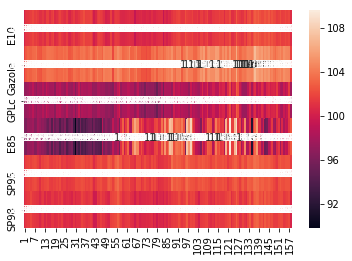

In [220]:
sns.heatmap(df_plot,annot=True)     

## Modeling : option 1

#### Build a model to forecast the price of a given gas for the next week :

In [23]:
from pyspark.sql.functions import lag
from pyspark.sql.window import Window
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import DenseVector

We are interested only by the the week index, the avg price (of the week) and the gas_id. Then we will create a dataframe with these variables and the price of the week before and 2 weeks before. 

In [24]:
ddf1=ddf.select("avg_price","Index","gas_id").distinct()

w = Window().partitionBy("gas_id").orderBy("Index")

ddf1 = ddf1.withColumn("price_last_week", lag("avg_price", 1).over(w))
ddf1 = ddf1.withColumn("price_2_weeks_bef", lag("avg_price", 2).over(w))

In [25]:
ddf1.show(5)

+------------------+-----+------+------------------+------------------+
|         avg_price|Index|gas_id|   price_last_week| price_2_weeks_bef|
+------------------+-----+------+------------------+------------------+
|1222.1208775654636|    1|     1|              null|              null|
| 1333.624184460261|    2|     1|1222.1208775654636|              null|
|1323.5956594071386|    3|     1| 1333.624184460261|1222.1208775654636|
|1323.0351362683439|    4|     1|1323.5956594071386| 1333.624184460261|
|1324.1694572217111|    5|     1|1323.0351362683439|1323.5956594071386|
+------------------+-----+------+------------------+------------------+
only showing top 5 rows



For each gas, the rows corresponding to the two first weeks will have at least one null value. To do the regression we need to delete them. 

In [26]:
ddf1=ddf1.filter(ddf1.price_2_weeks_bef.isNotNull())

In [27]:
ddf1.printSchema()

root
 |-- avg_price: double (nullable = true)
 |-- Index: integer (nullable = true)
 |-- gas_id: integer (nullable = true)
 |-- price_last_week: double (nullable = true)
 |-- price_2_weeks_bef: double (nullable = true)



First I will construct my forecasting model for the gas_type equal to 1 (so it is the Gazole).

In [28]:
ddf1=ddf1[ddf1["gas_id"]==1]

In [29]:
ddf1.show(5)

+------------------+-----+------+------------------+------------------+
|         avg_price|Index|gas_id|   price_last_week| price_2_weeks_bef|
+------------------+-----+------+------------------+------------------+
|1323.5956594071386|    3|     1| 1333.624184460261|1222.1208775654636|
|1323.0351362683439|    4|     1|1323.5956594071386| 1333.624184460261|
|1324.1694572217111|    5|     1|1323.0351362683439|1323.5956594071386|
|  1320.71409848343|    6|     1|1324.1694572217111|1323.0351362683439|
|1328.5639078498293|    7|     1|  1320.71409848343|1324.1694572217111|
+------------------+-----+------+------------------+------------------+
only showing top 5 rows



Now we need to combine the features in one unique variable. To do that, we create a dataframe thanks to the sparkSession and we put the avg_price as label and price_last_week and price_2_weeks_bef as features. Then we will initialize the linear regression.

In [30]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
   .master("local") \
   .appName("Linear Regression Model") \
   .config("spark.executor.memory", "1gb") \
   .getOrCreate()
   

In [31]:
# create dataframe composed of label and features.
data = ddf1.rdd.map(lambda x: (x[0], DenseVector(x[3:])))
ddf2 = spark.createDataFrame(data, ["label", "features"])

In [32]:
ddf2.show(5)

+------------------+--------------------+
|             label|            features|
+------------------+--------------------+
|1323.5956594071386|[1333.62418446026...|
|1323.0351362683439|[1323.59565940713...|
|1324.1694572217111|[1323.03513626834...|
|  1320.71409848343|[1324.16945722171...|
|1328.5639078498293|[1320.71409848343...|
+------------------+--------------------+
only showing top 5 rows



In [36]:
# Initialize `linear regression
lr = LinearRegression(labelCol="label")

Before testing the model, we need to create two samples : the training sample to construct the model and the test sample to validate the model.

In [37]:
train_ddf2,test_ddf2 = ddf2.randomSplit([0.7,0.3])

We can check if it's coherent : 

In [34]:
assert ddf2.count()==train_ddf2.count()+ test_ddf2.count(),"Problem"  

If we want to use the function pipeline we can do : 

In [38]:
from pyspark.ml import Pipeline

pipeline= Pipeline(stages=[lr]) 
linearModel=pipeline.fit(train_ddf2)

# Generate predictions
predicted = linearModel.transform(test_ddf2)

# Extract the predictions and the "known" correct labels
predictions = predicted.select("prediction").rdd.map(lambda x: x[0])
labels = predicted.select("label").rdd.map(lambda x: x[0])

# put predictions and labels into a list
predictionAndLabel = predictions.zip(labels).collect()

# Print out first 5 instances of `predictionAndLabel` 
display("predictions",predictionAndLabel[:5])

# Coefficients for the model
display("Coefficients for the model are ",linearModel.stages[0].coefficients)

'predictions'

[(1016.9268644537963, 1005.5529539616676),
 (1038.0229387723527, 1013.2293068704612),
 (1061.5019353600483, 1020.0784404888417),
 (1033.3722085348961, 1023.3101323407775),
 (1011.0049675847948, 1054.4851302708262)]

'Coefficients for the model are '

DenseVector([1.1512, -0.1803])

But as there is only one step in this pipeline,it's not very useful. That's why I don't use the pipeline to have more results about the linear regression easily : 

In [39]:
# Fit the data to the model
linearModel = lr.fit(train_ddf2)

In [41]:
# Generate predictions
predicted = linearModel.transform(test_ddf2)

# Extract the predictions and the "known" correct labels
predictions = predicted.select("prediction").rdd.map(lambda x: x[0])
labels = predicted.select("label").rdd.map(lambda x: x[0])

# put predictions and labels into a list
predictionAndLabel = predictions.zip(labels).collect()

# Print out first 5 instances of `predictionAndLabel` 
display("prediction",predictionAndLabel[:5])

# Coefficients for the model
display("Coefficients for the model are ",linearModel.coefficients)

display("We notice that it is exactly the same results than before so we can continue")

'prediction'

[(1016.9268644537963, 1005.5529539616676),
 (1038.0229387723527, 1013.2293068704612),
 (1061.5019353600483, 1020.0784404888417),
 (1033.3722085348961, 1023.3101323407775),
 (1011.0049675847948, 1054.4851302708262)]

'Coefficients for the model are '

DenseVector([1.1512, -0.1803])

'We notice that it is exactly the same results than before so we can continue'

#### Evaluation of the model : 

In [217]:
# Coefficients for the model
display("Coefficients for the model are ",linearModel.coefficients)

# Intercept for the model
display("The intercept for the model is",linearModel.intercept)

# Get the RMSE
display("The root Mean Squared Error is",linearModel.summary.rootMeanSquaredError)

# Get the R2
display("The R2 is",linearModel.summary.r2)

'Coefficients for the model are '

DenseVector([1.2159, -0.2569])

'The intercept for the model is'

46.316227196815184

'The root Mean Squared Error is'

21.699364107472547

'The R2 is'

0.9430064535160776

The R2 find is very good so the model is working fine. <br>

Now we can plot the forecast and the real price. 

Text(0,0.5,'forecast value')

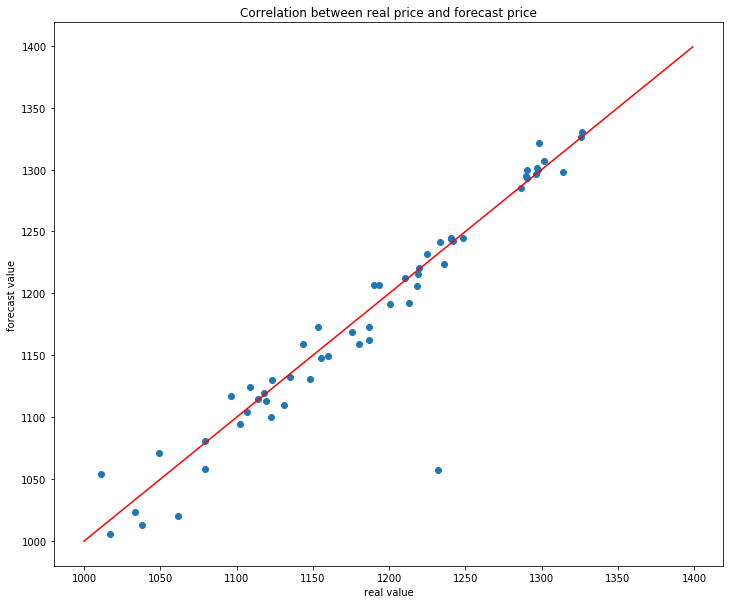

In [42]:
% matplotlib inline  
plt.figure(figsize=(12,10))

plt.scatter(predictions.collect(),labels.collect())
x=range(1000,1400)
plt.plot(x, x, color='red')
plt.title("Correlation between real price and forecast price")
plt.xlabel("real value")
plt.ylabel("forecast value")

The actual and the forecast prices are very correlated so it proofs again that the model found is very good.

We can do it for every gas and see if predict the next week thanks to the week before and 2 weeks before is enough for every type of gas.

In [272]:
ddf_1=ddf.select("avg_price","Index","gas_id").distinct()
w = Window().partitionBy("gas_id").orderBy("Index")

#-------------------------gas 1
ddf1=ddf_1[ddf_1["gas_id"]==1]
ddf1 = ddf1.withColumn("price_last_week", lag("avg_price", 1).over(w))
ddf1 = ddf1.withColumn("price_2_weeks_bef", lag("avg_price", 2).over(w))
ddf1=ddf1.filter(ddf1.price_2_weeks_bef.isNotNull())
# create dataframe composed of label and features.
data = ddf1.rdd.map(lambda x: (x[0], DenseVector(x[3:])))
ddf2 = spark.createDataFrame(data, ["label", "features"])
# Initialize `linear regression
lr = LinearRegression(labelCol="label")
train_ddf2,test_ddf2 = ddf2.randomSplit([0.7,0.3])
# Fit the data to the model
linearModel = lr.fit(train_ddf2)
# Generate predictions
predicted = linearModel.transform(test_ddf2)
# Extract the predictions and the "known" correct labels
predictions_1 =predicted.select("prediction").rdd.map(lambda x: x[0])
labels_1 =predicted.select("label").rdd.map(lambda x: x[0])


#-------------------------gas 2
ddf1=ddf_1[ddf_1["gas_id"]==2]
ddf1 = ddf1.withColumn("price_last_week", lag("avg_price", 1).over(w))
ddf1 = ddf1.withColumn("price_2_weeks_bef", lag("avg_price", 2).over(w))
ddf1=ddf1.filter(ddf1.price_2_weeks_bef.isNotNull())
# create dataframe composed of label and features.
data = ddf1.rdd.map(lambda x: (x[0], DenseVector(x[3:])))
ddf2 = spark.createDataFrame(data, ["label", "features"])
# Initialize `linear regression
lr = LinearRegression(labelCol="label")
train_ddf2,test_ddf2 = ddf2.randomSplit([0.7,0.3])
# Fit the data to the model
linearModel = lr.fit(train_ddf2)
# Generate predictions
predicted = linearModel.transform(test_ddf2)
# Extract the predictions and the "known" correct labels
predictions_2=predicted.select("prediction").rdd.map(lambda x: x[0])
labels_2=predicted.select("label").rdd.map(lambda x: x[0])

#-------------------------gas 3
ddf1=ddf_1[ddf_1["gas_id"]==3]
ddf1 = ddf1.withColumn("price_last_week", lag("avg_price", 1).over(w))
ddf1 = ddf1.withColumn("price_2_weeks_bef", lag("avg_price", 2).over(w))
ddf1=ddf1.filter(ddf1.price_2_weeks_bef.isNotNull())
# create dataframe composed of label and features.
data = ddf1.rdd.map(lambda x: (x[0], DenseVector(x[3:])))
ddf2 = spark.createDataFrame(data, ["label", "features"])
# Initialize `linear regression
lr = LinearRegression(labelCol="label")
train_ddf2,test_ddf2 = ddf2.randomSplit([0.7,0.3])
# Fit the data to the model
linearModel = lr.fit(train_ddf2)
# Generate predictions
predicted = linearModel.transform(test_ddf2)
# Extract the predictions and the "known" correct labels
predictions_3=predicted.select("prediction").rdd.map(lambda x: x[0])
labels_3=predicted.select("label").rdd.map(lambda x: x[0])

#-------------------------gas 4
ddf1=ddf_1[ddf_1["gas_id"]==4]
ddf1 = ddf1.withColumn("price_last_week", lag("avg_price", 1).over(w))
ddf1 = ddf1.withColumn("price_2_weeks_bef", lag("avg_price", 2).over(w))
ddf1=ddf1.filter(ddf1.price_2_weeks_bef.isNotNull())
# create dataframe composed of label and features.
data = ddf1.rdd.map(lambda x: (x[0], DenseVector(x[3:])))
ddf2 = spark.createDataFrame(data, ["label", "features"])
# Initialize `linear regression
lr = LinearRegression(labelCol="label")
train_ddf2,test_ddf2 = ddf2.randomSplit([0.7,0.3])
# Fit the data to the model
linearModel = lr.fit(train_ddf2)
# Generate predictions
predicted = linearModel.transform(test_ddf2)
# Extract the predictions and the "known" correct labels
predictions_4=predicted.select("prediction").rdd.map(lambda x: x[0])
labels_4=predicted.select("label").rdd.map(lambda x: x[0])


#-------------------------gas 5
ddf1=ddf_1[ddf_1["gas_id"]==5]
ddf1 = ddf1.withColumn("price_last_week", lag("avg_price", 1).over(w))
ddf1 = ddf1.withColumn("price_2_weeks_bef", lag("avg_price", 2).over(w))
ddf1=ddf1.filter(ddf1.price_2_weeks_bef.isNotNull())
# create dataframe composed of label and features.
data = ddf1.rdd.map(lambda x: (x[0], DenseVector(x[3:])))
ddf2 = spark.createDataFrame(data, ["label", "features"])
# Initialize `linear regression
lr = LinearRegression(labelCol="label")
train_ddf2,test_ddf2 = ddf2.randomSplit([0.7,0.3])
# Fit the data to the model
linearModel = lr.fit(train_ddf2)
# Generate predictions
predicted = linearModel.transform(test_ddf2)
# Extract the predictions and the "known" correct labels
predictions_5=predicted.select("prediction").rdd.map(lambda x: x[0])
labels_5=predicted.select("label").rdd.map(lambda x: x[0])
          
#-------------------------gas 6
ddf1=ddf_1[ddf_1["gas_id"]==6]
ddf1 = ddf1.withColumn("price_last_week", lag("avg_price", 1).over(w))
ddf1 = ddf1.withColumn("price_2_weeks_bef", lag("avg_price", 2).over(w))
ddf1=ddf1.filter(ddf1.price_2_weeks_bef.isNotNull())
# create dataframe composed of label and features.
data = ddf1.rdd.map(lambda x: (x[0], DenseVector(x[3:])))
ddf2 = spark.createDataFrame(data, ["label", "features"])
# Initialize `linear regression
lr = LinearRegression(labelCol="label")
train_ddf2,test_ddf2 = ddf2.randomSplit([0.7,0.3])
# Fit the data to the model
linearModel = lr.fit(train_ddf2)
# Generate predictions
predicted = linearModel.transform(test_ddf2)
# Extract the predictions and the "known" correct labels
predictions_6=predicted.select("prediction").rdd.map(lambda x: x[0])
labels_6=predicted.select("label").rdd.map(lambda x: x[0])
          

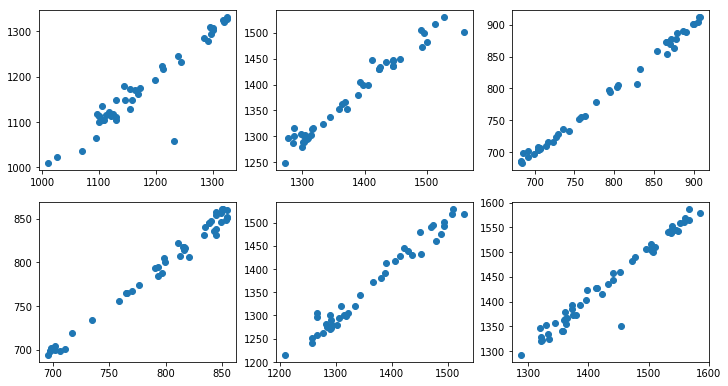

In [294]:
% matplotlib inline  

plt.figure(figsize=(12,10))
#plt.figure(1) 
plt.subplot(3,3,1) 
plt.scatter(predictions_1.collect(),labels_1.collect())

plt.subplot(3,3,2) 
plt.scatter(predictions_2.collect(),labels_2.collect())


plt.subplot(3,3,3) 
plt.scatter(predictions_3.collect(),labels_3.collect())

plt.subplot(3,3,4) 
plt.scatter(predictions_4.collect(),labels_4.collect())

plt.subplot(3,3,5) 
plt.scatter(predictions_5.collect(),labels_5.collect())

plt.subplot(3,3,6) 
plt.scatter(predictions_6.collect(),labels_6.collect())


We see that the prediction is good for every type of gas. So the  model is working for every type of gas.